In [51]:
import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# PATHS
if platform.system() == "Windows":
    FIGURES_PATH = Path(
        "C:\\Users\\JB\\github\\jbreda_animal_training\\figures\\mice\\cohort3"
    )
    DATA_PATH = Path("C:\\Users\\JB\\github\\jbreda_animal_training\\data\\days_dfs")
else:
    FIGURES_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/figures/mice/cohort3"
    )
    DATA_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/days_dfs"
    )

# ANIMALS
ANIMAL_IDS = ["R010"]

# DATES
# date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=20)
date_min, date_max = dju.return_date_window(latest_date="2023-11-09", n_days_back=5)
# few_days_ago = (datetime.today() - timedelta(days=4)).strftime("%Y-%m-%d")
today = datetime.today().date()

# LOAD IN TRIALS DATA
trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min="2023-11-09", date_max="2023-11-09"
)
trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min=date_min, date_max=date_max
)

fetched 1 sessions for R010 between 2023-11-09 and 2023-11-09
fetched 6 sessions for R010 between 2023-11-04 and 2023-11-09


In [ ]:
below: make pro-anti daily plot better

In [63]:
def mutliplot_cpoke_pro_anti(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for cpoke stages when pro-anti is on

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABCDDD
        EEEFGHHH
        IIIJKLLL
        MMMNOPQR
        SSSTUVVV
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # pu.identify_axes(ax_dict)  # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    plot_watering_amounts(trials_df, ax=ax_dict["C"])
    plot_cpoke_distributions(trials_df, ax=ax_dict["D"], mode="violations")

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["E"])
    plot_stage_info(trials_df, ax=ax_dict["E"])
    plot_side_bias_summary(trials_df, ax=ax_dict["F"])
    plot_side_count_summary(trials_df, ax=ax_dict["G"])
    try:
        plot_violations_by_period(trials_df, ax=ax_dict["H"])
    except:
        print("skipping violations by period due to hist error")

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["I"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["J"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["K"])
    plot_cpokes_over_trials(trials_df, ax=ax_dict["L"], mode="violations")

    ## ROW 4
    plot_pro_anti_perf_rates(trials_df, ax=ax_dict["M"])
    try:
        plot_stim_grid_performance(trials_df, ax=ax_dict["N"], mode="hits")
        plot_stim_grid_performance(trials_df, ax=ax_dict["O"], mode="violations")
        plot_hit_rate_by_give(trials_df, ax=ax_dict["Q"])  # todo swich to pa
    except:
        print("skipping stim/give plots due to hist error")
    plot_result_by_give(trials_df, ax=ax_dict["P"])  # todo switch to pa
    plot_npokes_summary(trials_df, ax=ax_dict["R"])

    ## ROW 5
    plot_antibias_r_probs(trials_df, ax=ax_dict["S"])
    # plot_give_info(trials_df, ax=ax_dict["T"])
    plot_trial_dur(trials_df, ax=ax_dict["V"])

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

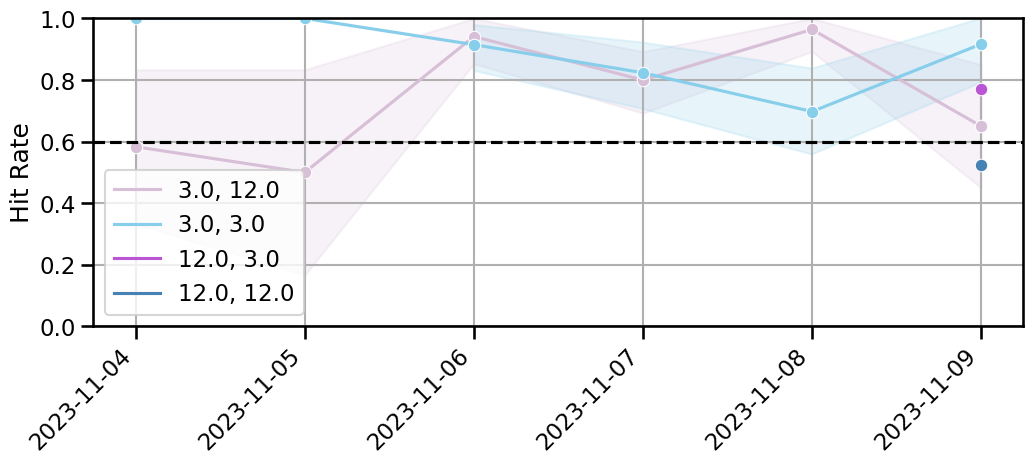

In [70]:
fig, ax = pu.make_fig()
plot_stim_performance(trials_df, ax)

In [68]:
def plot_stim_performance(trials_df, ax, group="date", title="", xaxis_label=True):
    """
    Plot performance by sa, sb pair on all trials
    trials across days

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `date`, `sound_pair`,
        `give_type_imp` and `hits` with trials as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str, (default = "")
        title of plot
    xaxis_label : bool (optional, default = True)
        whether to include the xaxis label or not, this is useful when
        plotting multiple plots on the same figure
    """

    # when hits remains in pyarrow format, the groupby
    # doesn't work properly for some edge cases
    # trials_df = trials_df.copy()
    # trials_df["hits"] = trials_df["hits"].astype("float64")

    # stim_perf = trials_df.groupby([group, "sound_pair"]).hits.mean().reset_index()

    sns.lineplot(
        data=trials_df,
        x=group,
        y="hits",
        hue="sound_pair",
        palette=pu.create_palette_given_sounds(trials_df),
        marker="o",
        ax=ax,
    )

    ax.grid()
    ax.axhline(0.6, color="k", linestyle="--")
    ax.set(title=title, xlabel="", ylabel="Hit Rate", ylim=(0, 1))
    pu.set_date_x_ticks(ax, xaxis_label)
    ax.legend(loc="lower left")

    return None

['s_a', 's_b', 'go']


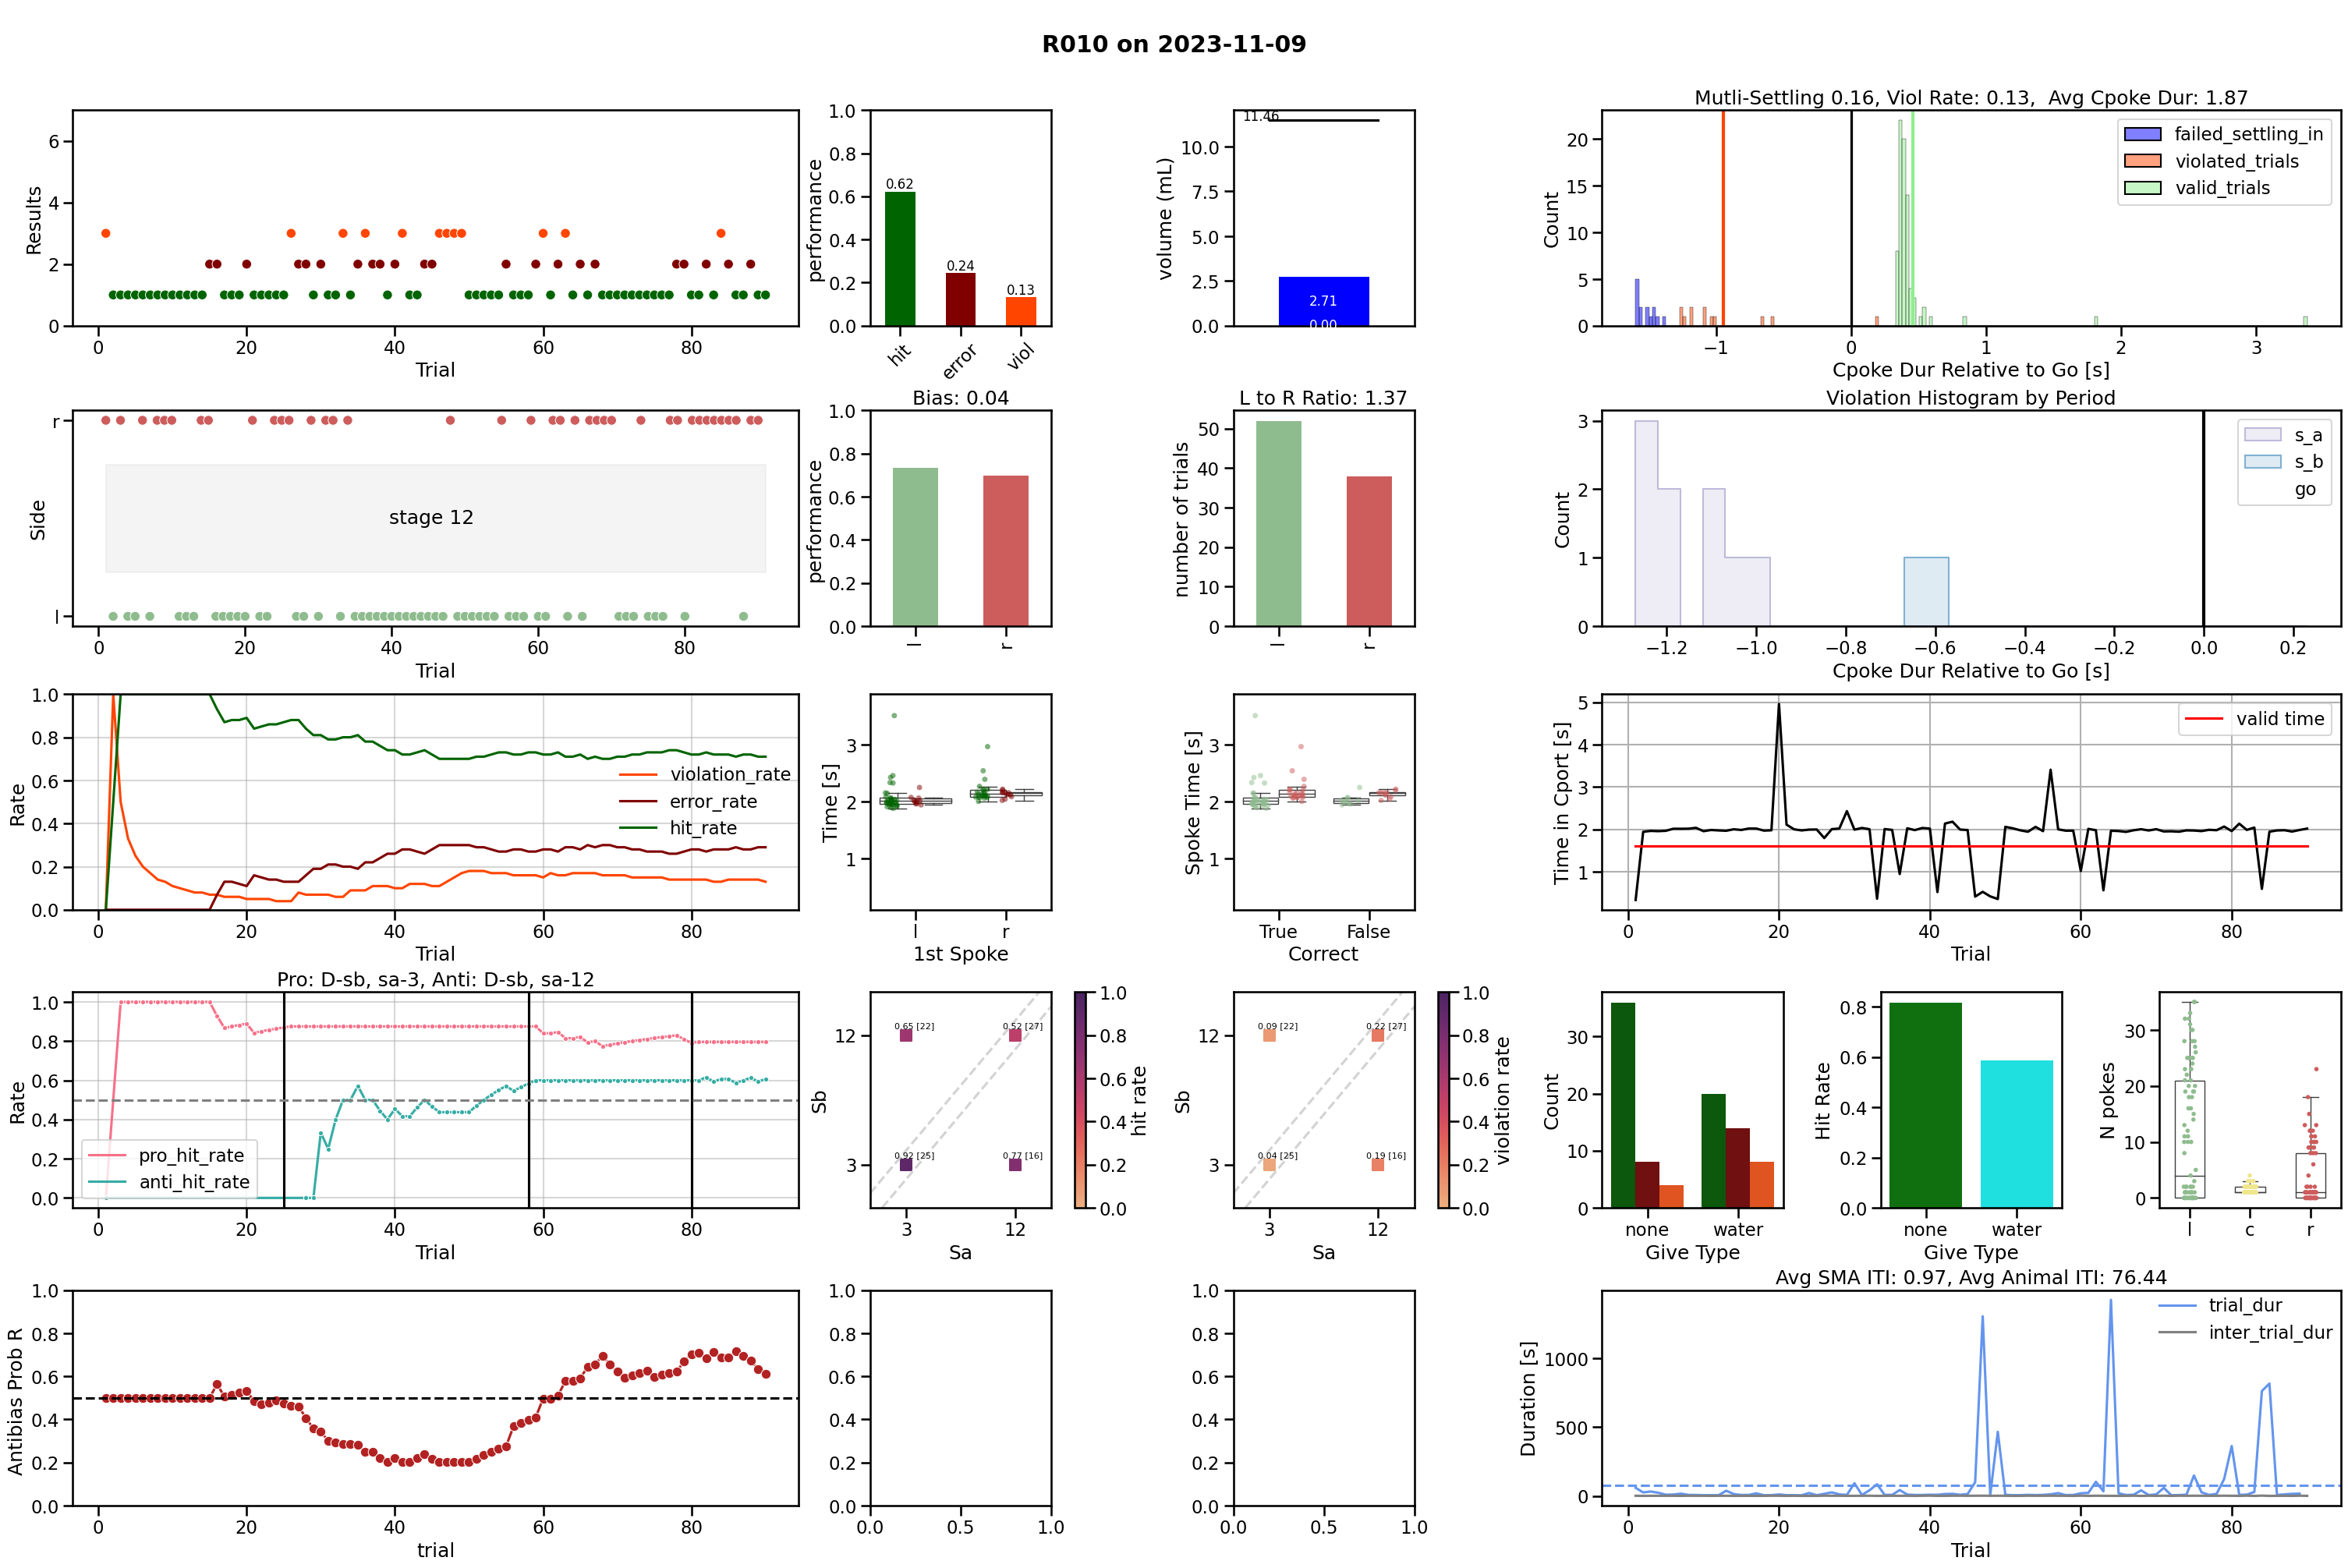

In [64]:
mutliplot_cpoke_pro_anti(trials_df)

In [ ]:
def plot_pro_anti_count_summary(trials_df, ax, title=""):
    """
    plot the count of pro/anti types implemented and color by
    what was actually set in the GUI

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `give_type_imp` and `give_type_set`
        with trials as row index
    ax : matplotlib.axes
        axis to plot to

    """
    # summarize counts
    count_data = (
        trials_df.groupby(["pr", "give_type_set"])
        .size()
        .reset_index(name="count")
    )
    # make the names shorter for plotting
    mapping = {"water_and_light": "w + l", "water": "w", "light": "l", "none": "n"}
    count_data.replace(
        {"give_type_imp": mapping, "give_type_set": mapping}, inplace=True
    )

    # plot
    sns.barplot(
        data=count_data,
        x="give_type_imp",
        y="count",
        hue="give_type_set",
        palette=pu.get_give_colors(count_data["give_type_imp"]),
        hue_order=pu.get_give_order(count_data["give_type_imp"]),
        ax=ax,
    )
    # aesthetics
    ax.set(
        title="Give Stats" if title == "" else title,
        xlabel="Implemented",
        ylabel="Count",
    )
    ax.legend(title="Set")

    return None

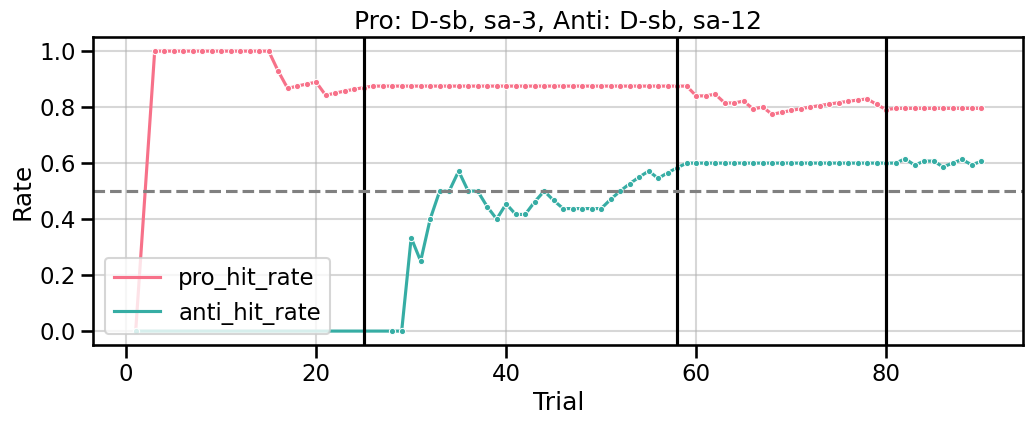

In [55]:
fig, ax = pu.make_fig()
plot_pro_anti_perf_rates(trials_df, ax=ax)

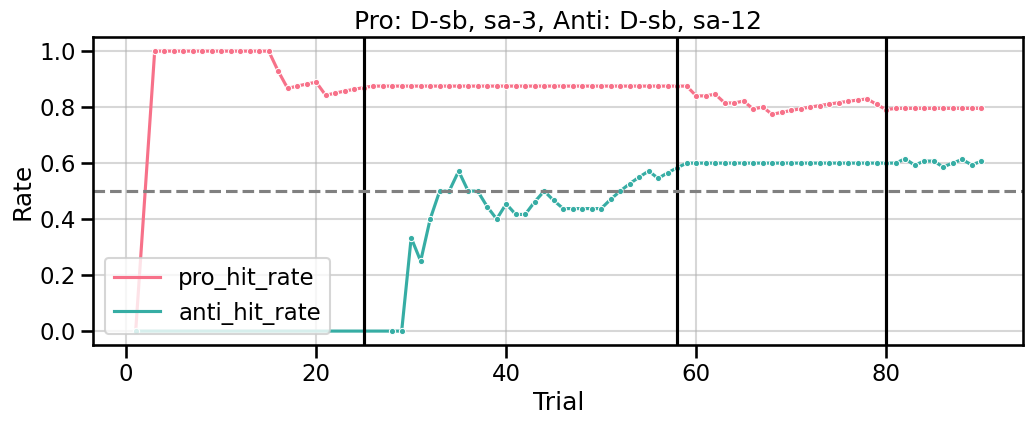

In [50]:
fig, ax = pu.make_fig()
perf_rates_df = pd.melt(
    trials_df,
    id_vars=["trial"],
    value_vars=["pro_hit_rate", "anti_hit_rate"],
    var_name="perf_type",
    value_name="rate",
)
sns.lineplot(
    data=perf_rates_df,
    x="trial",
    y="rate",
    hue="perf_type",
    hue_order=["pro_hit_rate", "anti_hit_rate"],
    palette="husl",
    ax=ax,
    marker=".",
)

block_switch = trials_df["n_blocks"].diff().fillna(0).abs() > 0
for trial in trials_df[block_switch].index:
    ax.axvline(x=trial, color="black")

ax.grid(alpha=0.5)
ax.axhline(y=0.5, color="gray", linestyle="--")


_ = ax.set(
    xlabel="Trial",
    ylabel="Rate",
    title=f"Pro: {trials_df.pro_stim_set.unique()[0]}, Anti: {trials_df.anti_stim_set.unique()[0]}",
)


ax.grid(alpha=0.5)
ax.legend(loc="lower left")

In [49]:
trials_df.pro_stim_set.unique()[0]

'D-sb, sa-3'

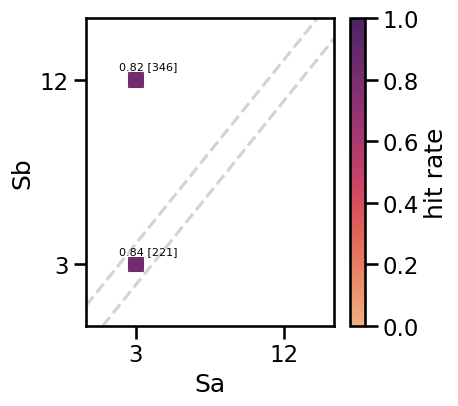

In [21]:
fig, ax = pu.make_fig("s")
plot_stim_grid_performance(trials_df, ax=ax, mode="hits")

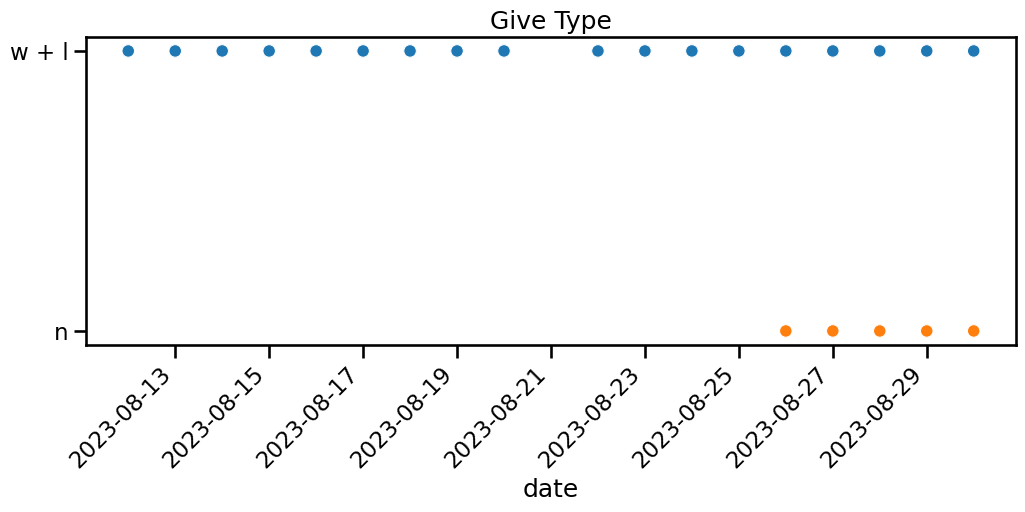

In [13]:
fig, ax = pu.make_fig()
xaxis_label = True
title = ""
legend = False

def plot_give_info_days(trials_df, ax, title="", xaxis_label=True, legend=False):
    """
    Plot the give information across days.

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `date` and
        `give_type_imp` with trials as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str, (default = "")
        title of plot
    xaxis_label : bool (optional, default = True)
        whether to include the xaxis label or not, this is useful when
        plotting multiple plots on the same figure
    legend : bool (optional, default = True)
        whether to include the legend or not
    

    """
    # make the names shorter for plotting
    data = trials_df[["date", "give_type_imp"]].copy()
    mapping = {"water_and_light": "w + l", "water": "w", "light": "l", "none": "n"}
    data.give_type_imp = data.give_type_imp.replace(mapping)

    sns.scatterplot(data=data, x="date", y="give_type_imp", hue="give_type_imp", ax=ax)

    _ = ax.set(title=title, ylabel="")

    pu.set_legend(ax, legend)
    pu.set_date_x_ticks(ax, xaxis_label)

In [16]:
trials_df.query("give_type_imp == 'none'")

,trial,animal_id,date,sess_id,result,hits,violations,temperror,hit_rate,error_rate,...,r_water_vol,ab_l_prob,ab_r_prob,ab_beta,ab_tau,exp_del_tau,exp_del_min,exp_del_max,sound_pair,min_time_to_spoke
19,20,R015,2023-08-30,926918,1,1,0,0,0.93,0.07,...,35.0,0.440723,0.559277,3.0,30.0,1.3,1.0,2.0,"12.0, 12.0",3.3910
34,35,R015,2023-08-30,926918,1,1,0,0,0.97,0.03,...,35.0,0.476583,0.523417,3.0,30.0,1.3,1.0,2.0,"3.0, 3.0",3.6628
35,36,R015,2023-08-30,926918,2,0,0,0,0.97,0.03,...,35.0,0.476583,0.523417,3.0,30.0,1.3,1.0,2.0,"3.0, 12.0",3.4348
44,45,R015,2023-08-30,926918,2,0,0,0,0.95,0.05,...,35.0,0.435917,0.564083,3.0,30.0,1.3,1.0,2.0,"12.0, 3.0",3.6241
53,54,R015,2023-08-30,926918,2,0,0,0,0.94,0.06,...,35.0,0.414314,0.585686,3.0,30.0,1.3,1.0,2.0,"12.0, 3.0",4.0003
60,61,R015,2023-08-30,926918,3,<NA>,1,<NA>,0.93,0.07,...,35.0,0.400070,0.599930,3.0,30.0,1.3,1.0,2.0,"3.0, 3.0",NaN
69,70,R015,2023-08-30,926918,1,1,0,0,0.94,0.06,...,35.0,0.426704,0.573296,3.0,30.0,1.3,1.0,2.0,"3.0, 3.0",3.6807
71,72,R015,2023-08-30,926918,3,<NA>,1,<NA>,0.94,0.06,...,35.0,0.431097,0.568903,3.0,30.0,1.3,1.0,2.0,"12.0, 3.0",NaN
77,78,R015,2023-08-30,926918,2,0,0,0,0.94,0.06,...,35.0,0.431097,0.568903,3.0,30.0,1.3,1.0,2.0,"3.0, 12.0",3.5159
94,95,R015,2023-08-30,926918,1,1,0,0,0.94,0.06,...,35.0,0.433658,0.566342,3.0,30.0,1.3,1.0,2.0,"12.0, 12.0",3.6830


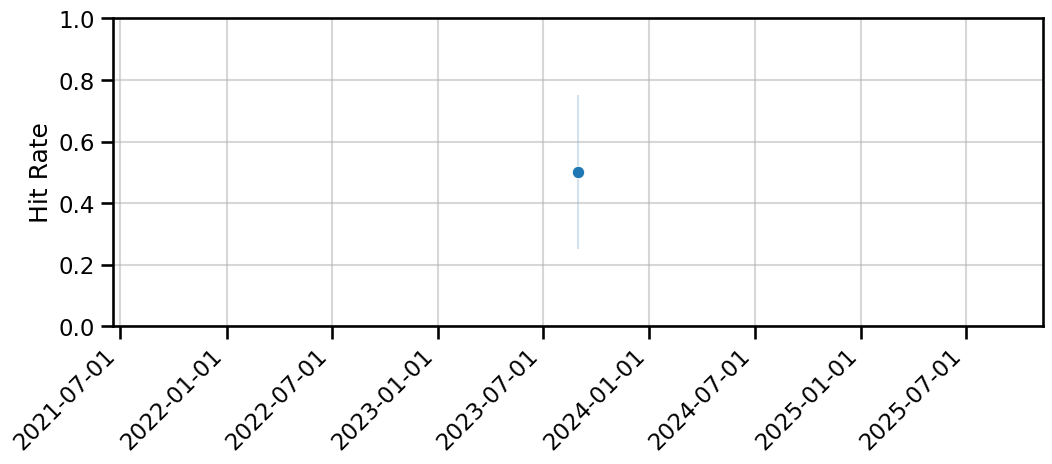

In [18]:
fig, ax = pu.make_fig()


def plot_non_give_performance(trials_df, ax, title=""):
    """
    geneate a plot of hit rate for non-give trials

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `hits` and
        `give_type_imp` with trials as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str, (default = "")
        title of plot
    """
    sns.lineplot(
        data=trials_df.query("give_type_imp == 'none'"),
        x="date",
        y="hits",
        marker="o",
        ax=ax,
    )
    # aethetics
    pu.set_date_x_ticks(ax, True)
    _ = ax.set(ylabel="Hit Rate", xlabel="", title=title, ylim=(0, 1))
    ax.grid(alpha=0.5)


plot_non_give_performance(trials_df, ax)

In [19]:
multi_day_trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min="2023-08-01"
)

fetched 23 sessions for R015 between 2023-08-01 and 2023-08-31


In [46]:
def mutliplot_cpoke_decrease_give(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for cpoke stages sounds are just being turned on
    the key thing to visualize here is the duration of the sound stimuli
    relative to the delay & the violation rate wrt periods

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABCDDD
        EEEFGHHH
        IIIJKLLL
        MMMNOPQR
        SSSTUVVV
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # pu.identify_axes(ax_dict)  # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    plot_watering_amounts(trials_df, ax=ax_dict["C"])
    plot_cpoke_distributions(trials_df, ax=ax_dict["D"], mode="violations")

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["E"])
    plot_stage_info(trials_df, ax=ax_dict["E"])
    plot_side_bias_summary(trials_df, ax=ax_dict["F"])
    plot_side_count_summary(trials_df, ax=ax_dict["G"])
    plot_violations_by_period(trials_df, ax=ax_dict["H"])

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["I"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["J"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["K"])
    plot_cpokes_over_trials(trials_df, ax=ax_dict["L"], mode="violations")

    ## ROW 4
    plot_give_info(trials_df, ax=ax_dict["M"])
    plot_stim_grid_performance(trials_df, ax=ax_dict["N"], mode="hits")
    plot_stim_grid_performance(trials_df, ax=ax_dict["O"], mode="violations")
    plot_result_by_give(trials_df, ax=ax_dict["P"])
    plot_hit_rate_by_give(trials_df, ax=ax_dict["Q"])
    plot_npokes_summary(trials_df, ax=ax_dict["R"])

    ## ROW 5
    plot_antibias_r_probs(trials_df, ax=ax_dict["S"])
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["T"],
        mode="hits",
        title="Give perf",
    )
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["U"],
        mode="violations",
        title="Give perf",
    )
    plot_trial_dur(trials_df, ax=ax_dict["V"])

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

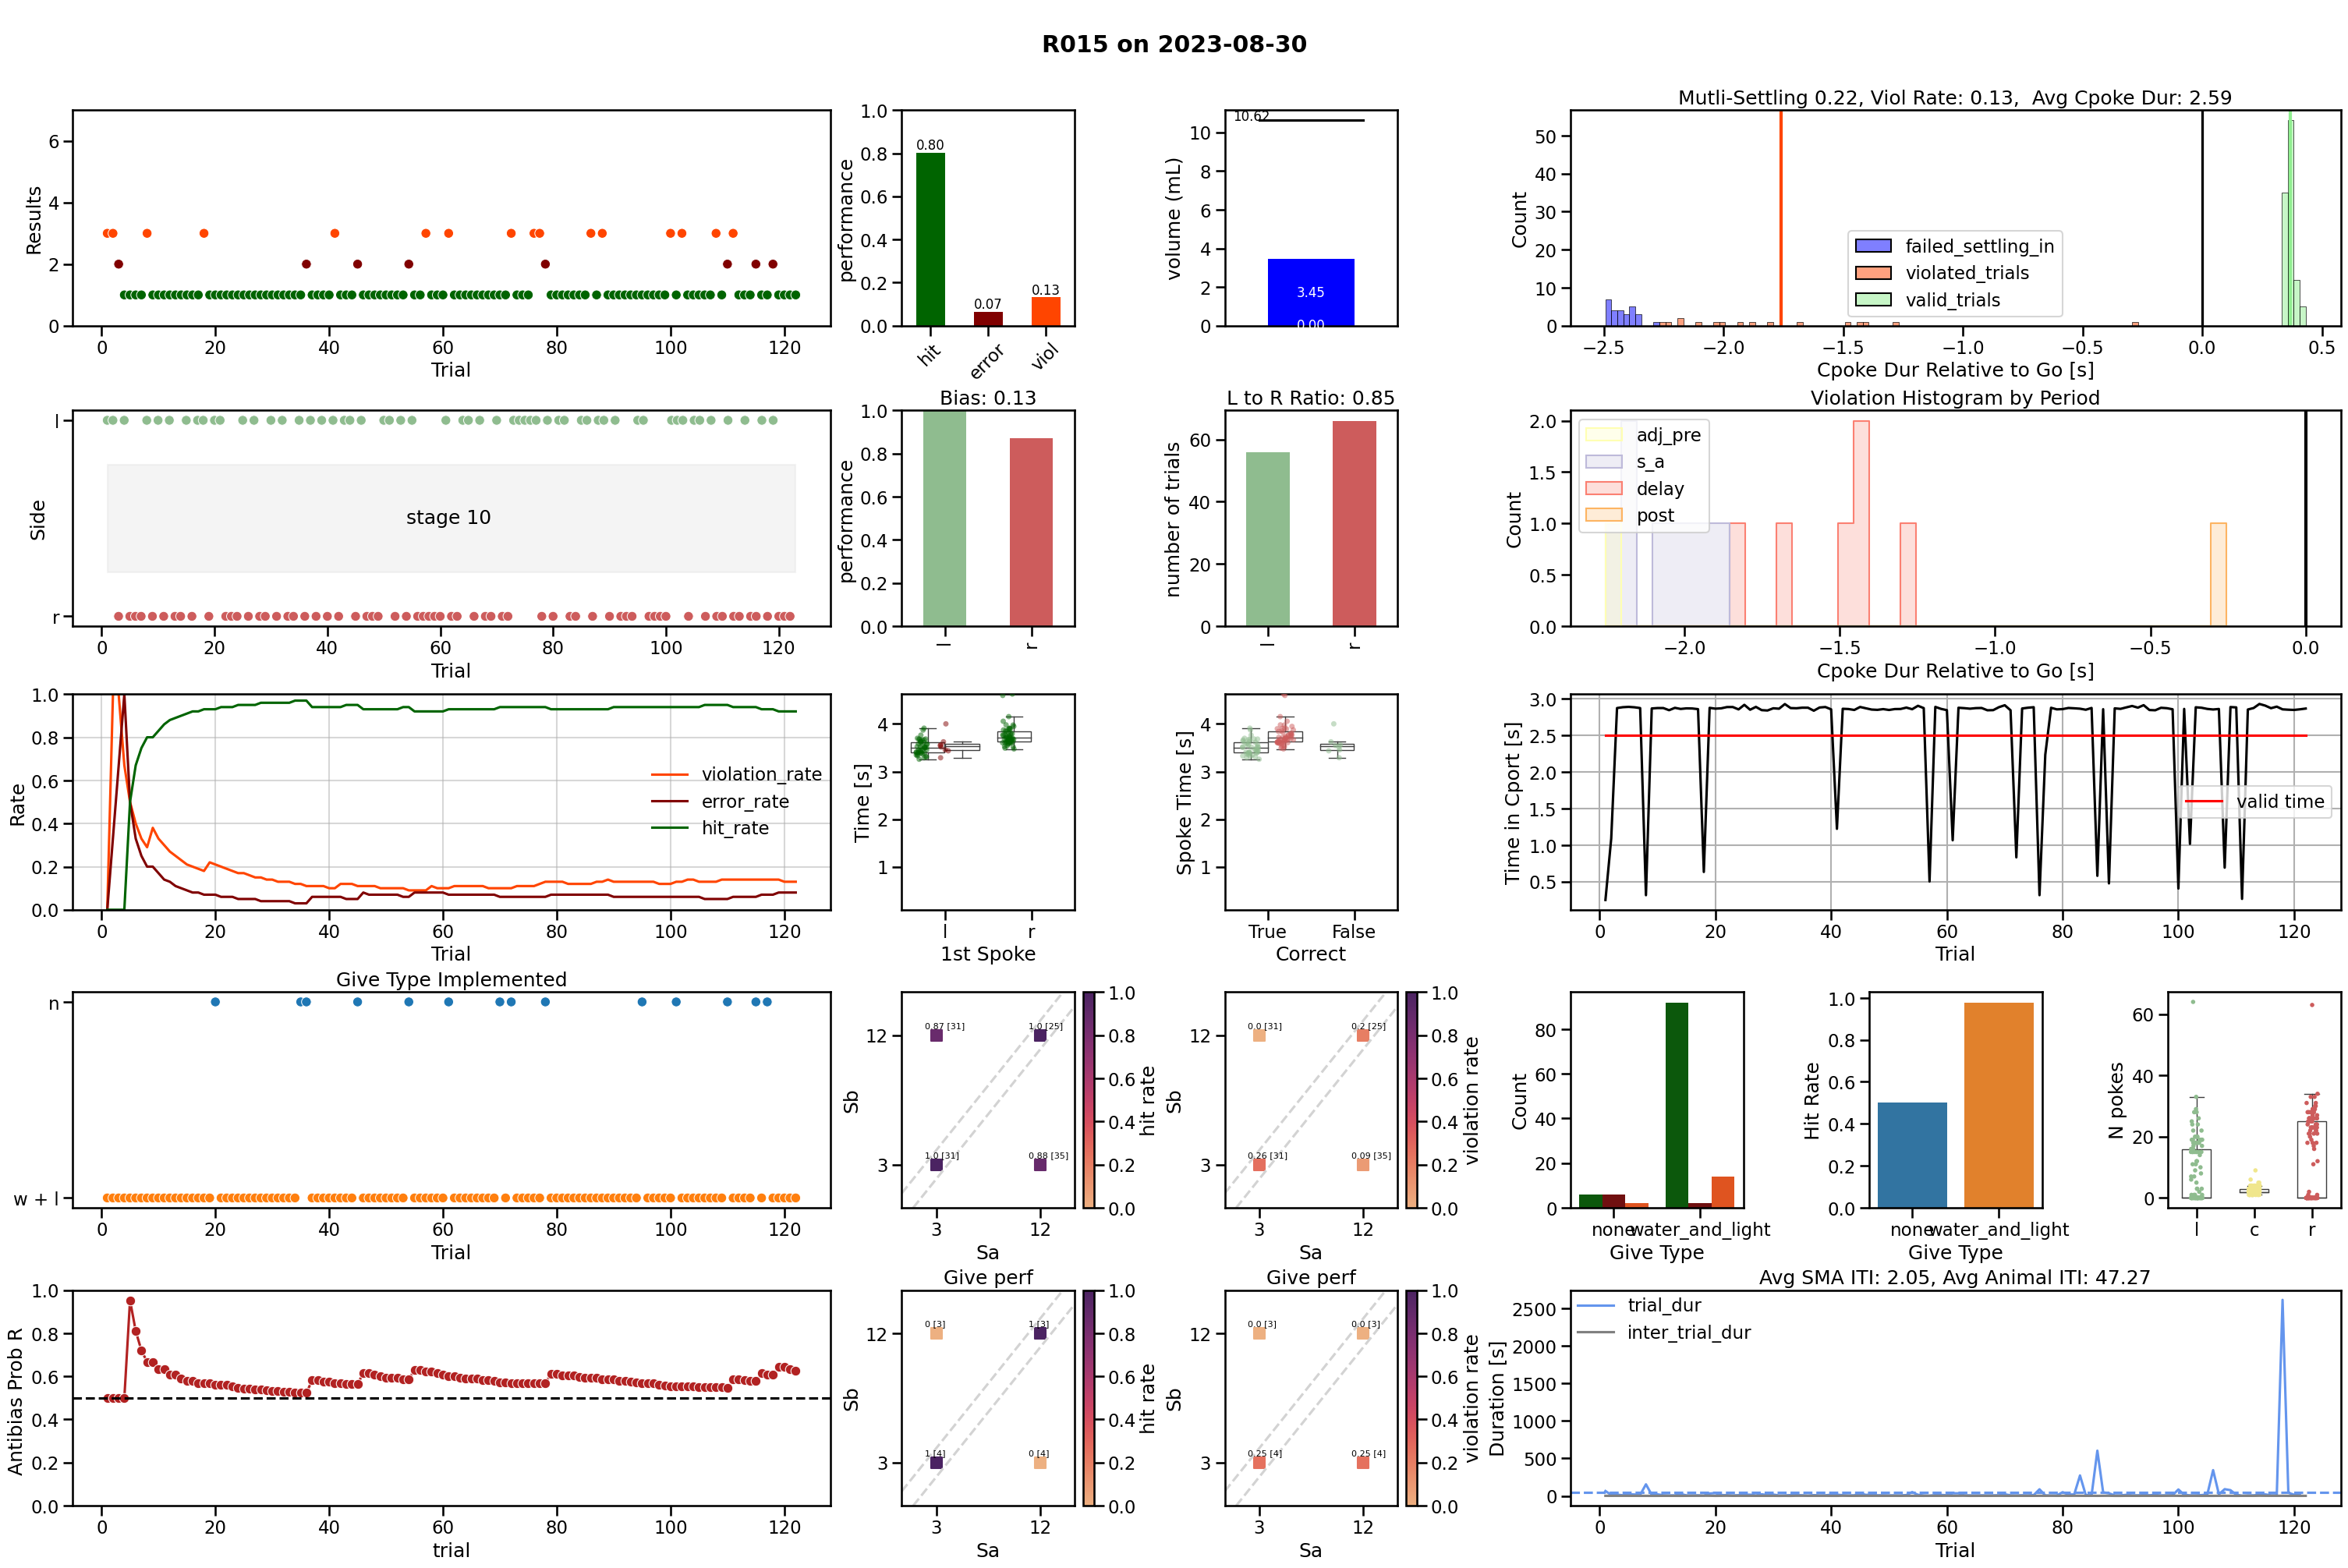

In [47]:
mutliplot_cpoke_decrease_give(trials_df)

final notes:
* will want to test tomorrow if this plot actual works in logic
* will also want to add antibias plot to other earlier stages

In [7]:
FPATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/offline/cpoke_dur_debug"
trials_df = pd.read_csv(FPATH + "/r015.csv")
TRIALS = pd.read_csv(FPATH + "/all_cpokes.csv")

In [3]:
# f_name = "R01s_days_df.csv"

# # days_df.to_csv(DATA_PATH / f_name, index=False)


# days_df = lazy_load_days_summary_df(
#     date_min=date_min,
#     date_max="2023-08-02",
#     animal_ids=ANIMAL_IDS,
#     save_dir=DATA_PATH,
#     f_name=f_name,
#     save_out=False,
# )

making R014_2023-08-13_day_summary


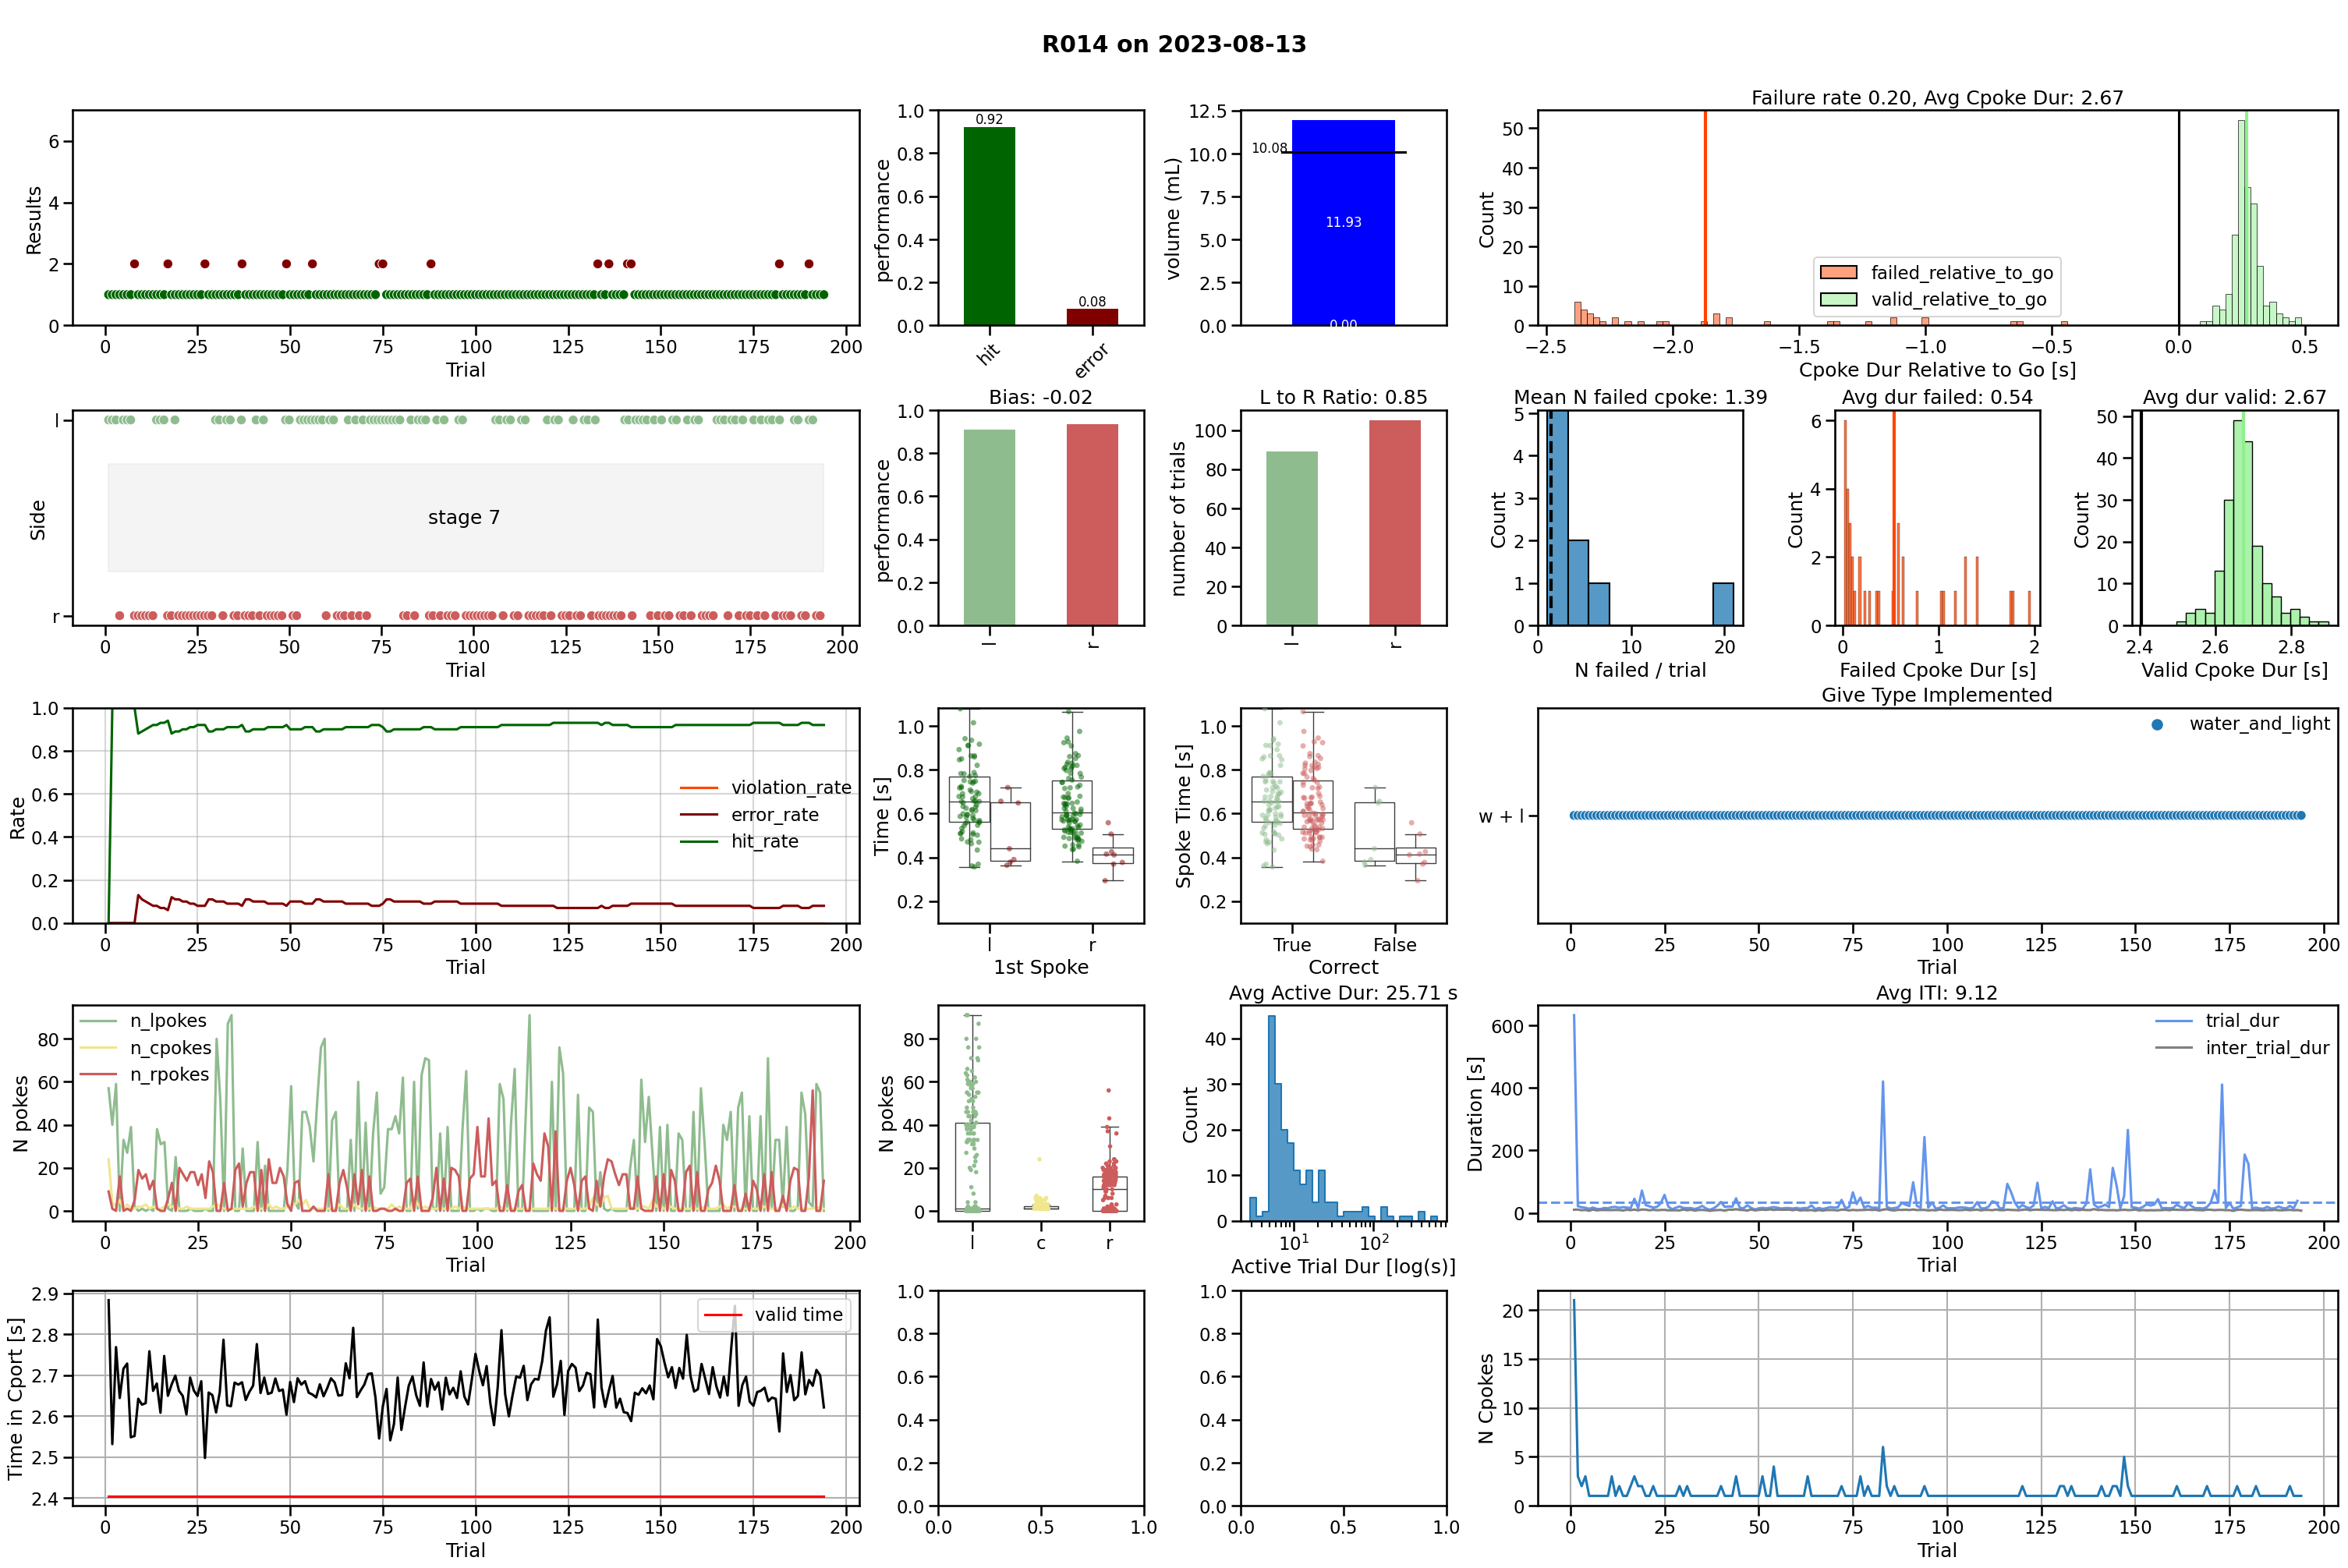

In [18]:
import os

fig_path = Path(
    "/Users/jessbreda/Desktop/github/jbreda_animal_training/code/training_performance"
)
multiplot_single_day_summaries(trials_df, fig_path, save_out=False, overwrite=False)

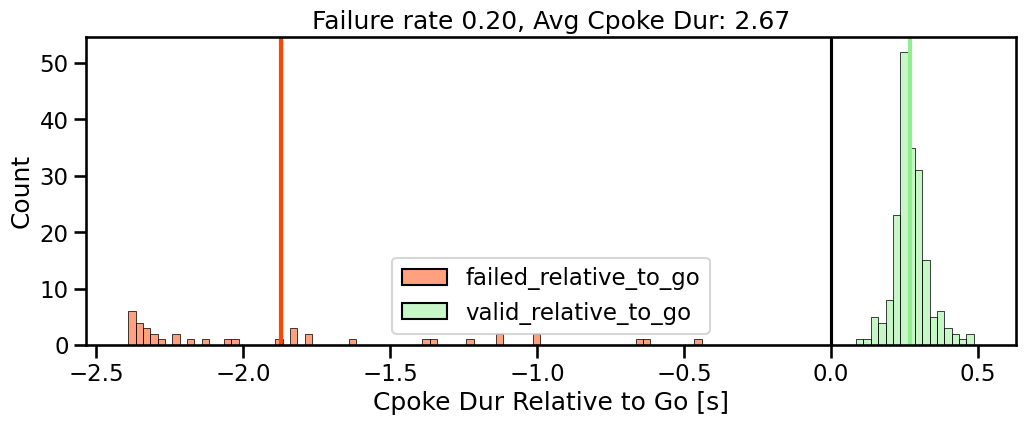

In [5]:
fig, ax = pu.make_fig()
plot_cpoke_distributions(trials_df, ax, mode="settling_in")

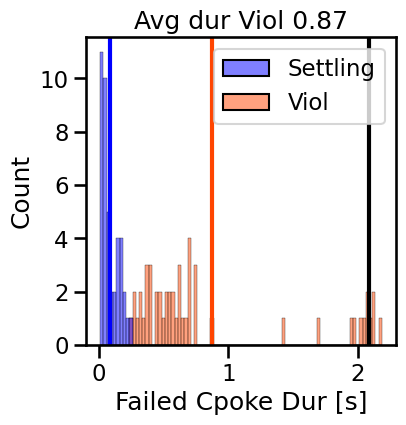

In [23]:
fig, ax = pu.make_fig("s")

plot_avg_failed_cpoke_dur(trials_df, ax, mode="violations")

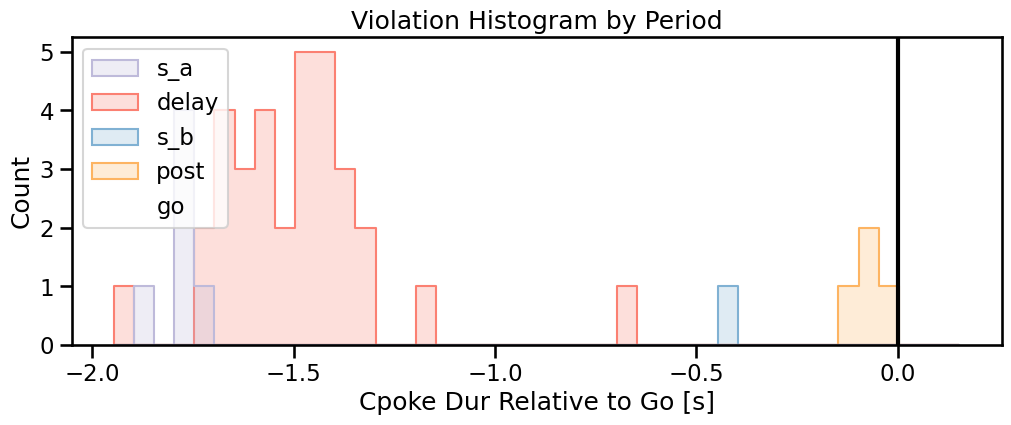

In [44]:
fig, ax = pu.make_fig()
_ = plot_violations_by_period(trials_df, ax)

EXTRA BITS

In [7]:
# plot the viol histogram relative to sa turning on.
# 1. filter for viol trials
# 2. find the time at which sa turned on
# 3. subtract from cpoke dur
# 4. plot histogram

# trials_df = trials_df.query("violations == 1").copy()
# trials_df = trials_df.assign(
#     sa_on_time=trials_df.apply(
#         lambda row: row["settling_in_dur"] + row["settling_in_dur"]
#     )

# trials_df["sa_on_time"] = trials_df["settling_in_dur"] + trials_df["adj_pre_dur"]
# trials_df["sa_off_time"] = sa_on_time + trials_df["stimulus_dur"]
# trials_df["sb_on_time"] = (
#     trials_df["settling_in_dur"]
#     + trials_df["adj_pre_dur"]
#     + trials_df["stimulus_dur"]
#     + trials_df["delay_dur"]
# )
# trials_df["sb_off_time"] = sb_on_time + trials_df["stimulus_dur"]
# viols_df["cpoke_rel_sa_start"] = viols_df.cpoke_dur - viols_df.sa_on_time
# viols_df["cpoke_rel_sa_end"] = viols_df.cpoke_dur - viols_df.sa_off_time
# viols_df["cpoke_rel_sb_start"] = viols_df.cpoke_dur - viols_df.sb_on_time
# viols_df["cpoke_rel_sb_end"] = viols_df.cpoke_dur - viols_df.sb_off_time

In [8]:
# columns_to_plot = [
#     "date",
#     "settling_in_dur",
#     "adj_pre_dur",
#     "stimulus_dur",
#     "delay_dur",
#     "post_dur",
#     "cpoke_dur",
#     "pre_go_dur",
#     "trial",
#     "violations",
# ]
# viols_df = trials_df[columns_to_plot].query("violations == 1")
# viols_df.insert(5, "s_b", viols_df["stimulus_dur"])
# viols_df.rename(columns={"stimulus_dur": "s_a"}, inplace=True)
# viols_df.columns = viols_df.columns.str.replace("_dur", "")
# # Calculate relative period times
# periods = [
#     "settling_in",
#     "adj_pre",
#     "s_a",
#     "delay",
#     "s_b",
#     "post",
# ]
# elapsed_time = 0
# for period in periods:
#     # if period == "settling_in":
#     viols_df[period + "_end"] = elapsed_time + viols_df[period]
#     elapsed_time = viols_df[period + "_end"].values


# def determine_period(row):
#     for period in periods:
#         if row["cpoke"] <= row[period + "_end"]:
#             return period
#     return "go"


# viols_df["violation_period"] = viols_df.apply(determine_period, axis=1)
# viols_df["cpoke"] = viols_df.cpoke - viols_df.pre_go

something really weird is going on- i looking at trial 23 on 08-04 and other trials. they should be violations, yet somehow the cpoke_dur is off. I don't understand how!

In [81]:
locs = [11, 22, 46, 47, 49, 61]  # where viol timing is off

In [79]:
viols_df.violation_period.isnull()

1      False
2      False
3      False
4      False
6      False
7      False
9      False
11      True
17     False
18     False
19     False
21     False
22      True
23     False
25     False
26     False
30     False
31     False
32     False
35     False
38     False
42     False
43     False
44     False
45     False
46      True
47      True
49      True
53     False
61      True
86     False
94     False
95     False
99     False
109    False
110    False
128    False
143    False
148    False
163    False
166    False
167    False
171    False
172    False
186    False
188    False
194    False
195    False
205    False
207    False
Name: violation_period, dtype: bool